In [55]:
import pandas as pd
import numpy as np
import time

# visual libraries
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')
# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [56]:
df = pd.read_csv('KDDTrain+.csv')
df['label'] = np.where(df['label'].str.contains('normal'), 0, 1)
df.head(2)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,data
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.0,0.0,0.0,0.05,0.0,0,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.0,0.0,0.0,0.00,0.0,0,15


In [57]:
df.shape

(125973, 43)

In [58]:
df.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [59]:
sum(df.label==0)*100/df.shape[0]

53.45828074269883

In [60]:
sum(df.label==1)*100/df.shape[0]

46.54171925730117

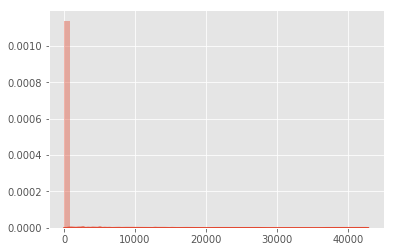

In [61]:
time = df['duration'].values
sns.distplot(time)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [63]:
proto=pd.get_dummies(df['protocol_type'],drop_first=False, prefix='proto')

In [64]:
serv=pd.get_dummies(df['service'],drop_first=False, prefix='serv')

In [65]:
flagg=pd.get_dummies(df['flag'],drop_first=False, prefix='flag')

In [66]:
final_data=pd.concat([df,proto,serv,flagg],axis=1)
final_data.drop(['protocol_type','service','flag'],axis=1,inplace=True)
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Columns: 124 entries, duration to flag_SH
dtypes: float64(15), int64(25), uint8(84)
memory usage: 48.5 MB


In [67]:
X = final_data.drop(['label'], axis = 1)
y = final_data['label']

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X.values)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.head()

,principal component 1,principal component 2,label
0,-45080.955113,-19767.258863,0
1,-45425.955109,-19767.168071,0
2,-45571.955118,-19767.129666,1
3,-45337.809729,-11614.191028,0
4,-45372.844627,-19347.182064,0


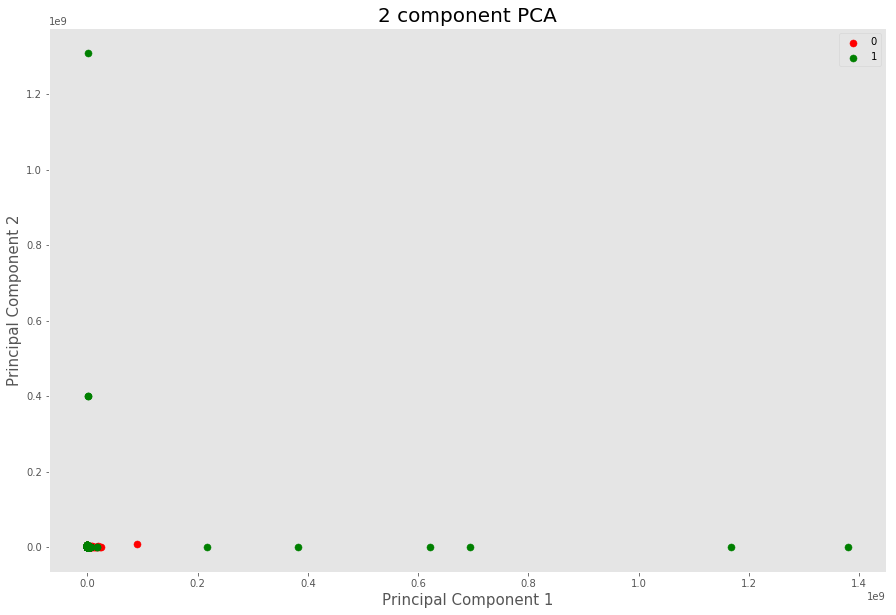

In [68]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [69]:
features = finalDf.drop(['label'], axis = 1)
labels = pd.DataFrame(finalDf['label'])

feature_array = features.values
label_array = labels.values
X_train,X_test,y_train,y_test = train_test_split(feature_array,label_array,test_size=0.20)

# normalize: Scale input vectors individually to unit norm (vector length).
X_train = normalize(X_train)
X_test=normalize(X_test)

In [73]:
neighbours = np.arange(1,40)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train,y_train.ravel())
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train.ravel())
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test.ravel())

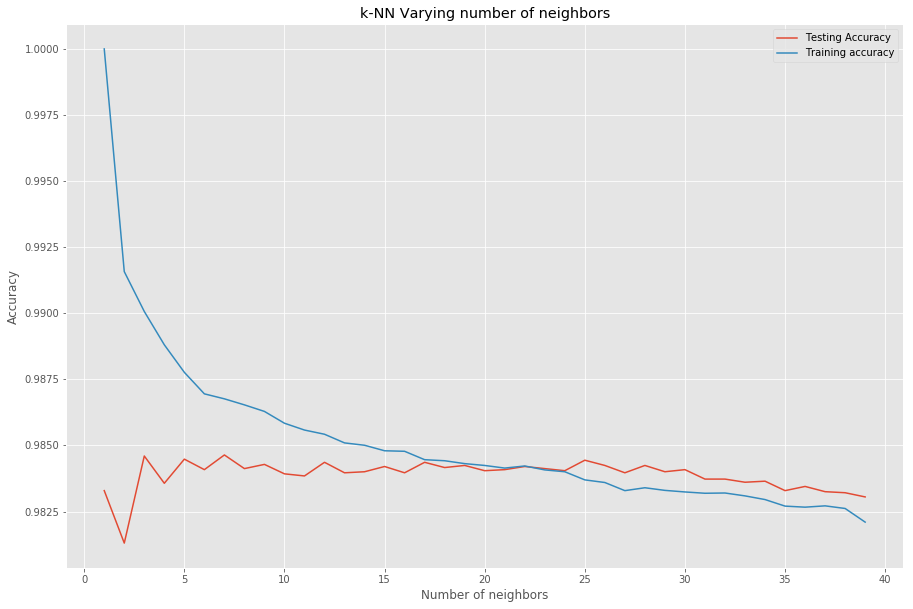

In [74]:
from pylab import rcParams
rcParams['figure.figsize'] = 15,10
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [75]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [76]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=7, p=2,
           weights='uniform')

In [77]:
# save the model to disk
filename = 'finalized_model.sav'
joblib.dump(knn, filename)

# load the model from disk
knn = joblib.load(filename)

In [78]:
# predicting labels for testing set
knn_predicted_test_labels=knn.predict(X_test)

Text(0.5, 1.0, ' Number of Blobs')

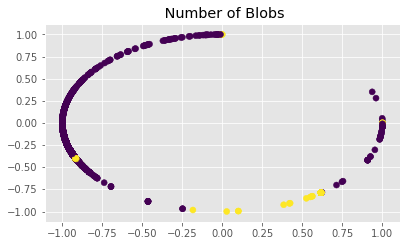

In [79]:
from pylab import rcParams
#plt.figure(figsize=(12, 12))
rcParams['figure.figsize'] = 14, 8
plt.subplot(222)
plt.scatter(X_test[:, 0], X_test[:, 1], c=knn_predicted_test_labels)
plt.title(" Number of Blobs")

In [80]:
#scoring knn
knn_accuracy_score  = accuracy_score(y_test,knn_predicted_test_labels)
knn_precison_score  = precision_score(y_test,knn_predicted_test_labels)
knn_recall_score    = recall_score(y_test,knn_predicted_test_labels)
knn_f1_score        = f1_score(y_test,knn_predicted_test_labels)
knn_MCC             =    matthews_corrcoef(y_test,knn_predicted_test_labels)

In [81]:
print(knn_accuracy_score)
print(knn_precison_score)
print(knn_recall_score)
print(knn_f1_score)
print(knn_MCC)

0.9846398094860092
0.9816226287262872
0.985545446815747
0.9835801264372693
0.9691580436950414
